# Sinusoid Regression
Notebook to run experiments on the sinusoid dataset.

Before running this notebook, you need to run the MAML, MetaSGD, Reptile, and supervised pretraining runs. To do so, execute the following command from the repository root directory:
`python tsfewshot/run_scheduler.py train --directory experiments/sinusoid/configs/ --runs-per-gpu 4 --gpu-ids 0`

This will run all config files in the specified directory, with 4 runs in parallel on GPU 0.

In [1]:
%load_ext autoreload
%autoreload 2
import copy
import pickle
import shutil
import sys
import os
from collections import defaultdict
from pathlib import Path

from importlib import reload
import logging
reload(logging)
logging.basicConfig(format='%(asctime)s %(levelname)s:%(message)s', datefmt='%I:%M:%S')

import matplotlib.pyplot as plt
from matplotlib import gridspec
import numpy as np
import pandas as pd
import scipy
import torch
from matplotlib import rc
from scipy.stats import wilcoxon
from tqdm import tqdm

sys.path.append('../..')
from tsfewshot.config import Config
from tsfewshot import plot, analyses
from tsfewshot.pcautils import get_best_epoch

np.random.seed(0)
torch.random.manual_seed(0)

DEVICE = 'cuda:0'
SUPPORT_SIZES = [5, 10, 20]
QUERY_SIZE = 100
MODEL_SIZE = 1761  # number of parameters in the 2-hidden-layer model

CODE_DIR = Path('../..')

rc('text', usetex=True)

In [105]:
# get the run directories from the meta-training phase
RUNS = {support: {'maml': list(Path('runs/').glob(f'*maml-{support}support*'))[0].resolve(),
                  'metasgd': list(Path('runs/').glob(f'*metasgd-{support}support*'))[0].resolve()}
        for support in SUPPORT_SIZES}
RUNS[5]['reptile'] = Path('runs/sinusoid-reptile-5support25batch10steplr1.0innerlr0.005-finetune10-seed0_220304_233419')
RUNS[10]['reptile'] = Path('runs/sinusoid-reptile-10support25batch10steplr1.0innerlr0.005-finetune10-seed0_220305_095203')
RUNS[20]['reptile'] = Path('runs/sinusoid-reptile-20support25batch10steplr1.0innerlr0.01-finetune10-seed0_220305_050308')
RUNS['no-pretrain'] = list(Path('runs/').glob('*no-pretrain*'))[0].resolve()
RUNS['supervised-pretrain'] = list(Path('runs/').glob('*supervised-pretrain*'))[0].resolve()

In [106]:
# create tasks on which we will generate the finetuning trajectories that
# will be used to calculate the preconditioning matrix
np.random.seed(0)
amps = np.random.uniform(0.1, 5.0, size=MODEL_SIZE)
phases = np.random.uniform(0, np.pi, size=MODEL_SIZE)

finetune_tasks = [f'{amp}#{amp}#{phase}#{phase}#-5.0#5.0' for amp, phase in zip(amps, phases)]

In [4]:
# create finetuning configurations for each of the above finetune_tasks
for support, run in [(support, RUNS[support]['maml']) for support in SUPPORT_SIZES] \
    + [(None, RUNS['no-pretrain']), (None, RUNS['supervised-pretrain'])]:
    epoch = 50000 if support is not None else get_best_epoch(run)
    (run / f'finetune_epoch{epoch}/configs').mkdir(exist_ok=True, parents=True)

    for i, task in enumerate(finetune_tasks):
        if i > 255 and support not in [5, None]:
            # we need more tasks for the subspace size ablation, which we do with support size 5.
            # for the other experiments, 256 tasks is (more than) sufficient.
            break
        cfg = Config(run / 'config.yml')

        cfg.update({
            'experiment_name': f'{cfg.experiment_name}-finetune-{task}',
            'batch_size': 64,
            'training_setup': 'supervised',
            # this is a quirk of tsfewshot: the "finetune" mode will finetune on the val_datasets
            # and evaluate on the test_datasets
            'val_datasets': [task],
            'test_datasets': [task],
            'finetune_lr': 0.001,
            'optimizer': 'adam',
            'finetune_epochs': 500,
            'eval_every': 1,
            'early_stopping_patience': 10,
            'finetune': False,
            'save_every': 1,
            'checkpoint_path': f'{run}/model_epoch{str(epoch).zfill(3)}.p',
            'base_run_dir': str(run),
            'run_dir': f'{str(run)}/finetune_epoch{epoch}'
        })

        cfg.dump_config(run / f'finetune_epoch{epoch}/configs/{task.replace("#", "").replace("/", "")}.yml')

Next, you need to start the created finetuning runs. For each MAML/supervised/random-initialization pretraining run, execute:
`python tsfewshot/run_scheduler.py finetune --directory /path/to/run/finetune_epochX/configs/ --gpu-ids 0 --runs-per-gpu 5`
(adapt gpu-ids and runs-per-gpu according to the number and size of your GPU(s)).

After all runs are completed, calculate the preconditioning matrix for each support size:
`python pca.py --base-dir /path/to/run --finetune-dirs /path/to/run/finetune_epochX/sinusoid* --epoch 50000` (`--epoch -1` for supervised/no-pretraining).
This will pickle the preconditioning matrix to `/path/to/run/pca/`.

In [107]:
ft_epochs = defaultdict(lambda: 200)

eval_every = list(range(20)) + list(range(20, 201, 10))
inner_seeds = [0]

type_specs = [
    'normal',  # SGD finetuning based on MAML initialization. Effectively, this is MAML.
    'normal-metasgd',  # finetuning of the MetaSGD initialization
    'normal-reptile',  # finetuning of the Reptile initialization
    'pca',  # our method
]

gridsearch_dir = 'optimizeFinetune'
test_tasks = ['0.1#5.0#0.0#3.141592654#-5.0#5.0']

def combinations(support, baseline=None):
    combinations = []
    for type_spec in type_specs:
        if (baseline is not None and baseline not in type_spec) or (baseline is None and type_spec not in ['normal', 'pca']):
            continue
        if type_spec == 'normal-metasgd':
            lrs = [2.0, 1.5, 1.0, 0.5, 0.1, 0.05]
        else:
            if 'pca' in type_spec:
                lrs = [2.0, 1.0, 0.5, 0.1, 0.05, 0.01, 0.005]
            else:
                lrs = [0.1, 0.05, 0.01, 0.005, 0.001, 0.0005, 0.0001]
        for lr in lrs:
            combinations.append({'support': support,
                                 'lr': lr,
                                 'type': type_spec,
                                 'noise': 0.0,
                                 'sparsity': None,
                                })
    return combinations
    
len(combinations(5))

14

In [108]:
# create gridsearch for optimal learning rate and number of update steps during finetuning.
new_runs = []
cfg_update = {
    'batch_size': 64,
    'training_setup': 'supervised',
}
for support in SUPPORT_SIZES:
    new_runs += analyses.create_gridsearch_dirs(RUNS[support]['maml'],
                                                combinations(support),
                                                gridsearch_dir,
                                                inner_seeds,
                                                n_trajectories=-1,
                                                query_size=QUERY_SIZE,
                                                ft_epochs=ft_epochs,
                                                eval_every=eval_every,
                                                save_predictions=False,
                                                optimizer='sgd-squared',
                                                val_datasets=test_tasks,
                                                n_dataset_evals=100,
                                                init_epoch=50000,
                                                tasks_ds_cfg=cfg_update,
                                                pca_file_path=RUNS[support]['maml'] / 'pca/pca-torchcenterFalseNonecomponentspathNoneimprovedFalseusestepsNonelayerwiseFalse.p')
    for method in ['metasgd', 'reptile']:
        new_runs += analyses.create_gridsearch_dirs(RUNS[support][method],
                                                    combinations(support, baseline=method),
                                                    gridsearch_dir,
                                                    inner_seeds,
                                                    n_trajectories=-1,
                                                    query_size=QUERY_SIZE,
                                                    ft_epochs=ft_epochs,
                                                    eval_every=eval_every,
                                                    save_predictions=False,
                                                    optimizer='sgd',
                                                    val_datasets=test_tasks,
                                                    n_dataset_evals=100,
                                                    tasks_ds_cfg={'batch_size': 64},
                                                    init_epoch=50000 if method == 'metasgd' else None)
    for method in ['no-pretrain', 'supervised-pretrain']:
        new_runs += analyses.create_gridsearch_dirs(RUNS[method],
                                                combinations(support),
                                                gridsearch_dir,
                                                inner_seeds,
                                                n_trajectories=-1,
                                                query_size=QUERY_SIZE,
                                                ft_epochs=ft_epochs,
                                                eval_every=eval_every,
                                                save_predictions=False,
                                                optimizer='sgd-squared',
                                                val_datasets=test_tasks,
                                                n_dataset_evals=100,
                                                tasks_ds_cfg=cfg_update,
                                                pca_file_path=RUNS[method] / 'pca/pca-torchcenterFalseNonecomponentspathNoneimprovedFalseusestepsNonelayerwiseFalse.p')

100%|██████████| 14/14 [00:00<00:00, 2171.53it/s]


Next, run the created gridsearch configurations via:
`python tsfewshot/run_scheduler.py eval --directory /path/to/run/optimizeFinetune/ --epoch 50000 --split val --gpu-ids 0 --runs-per-gpu 5` (`--epoch -1` for supervised/no-pretraining).
You will need to run this command for each pretraining run (MAML/MetaSGD/Reptile at each support size).

In [110]:
methods = ['maml', 'metasgd', 'reptile', 'no-pretrain', 'supervised-pretrain']
best_ft_options = {m: {} for m in methods}
best_ft_epochs = {m: {} for m in methods}
gridsearch_results = {m: {} for m in methods}

In [111]:
# load the gridsearch results and calculate the best learning rate and number of update steps
# for each support size and each method.
# For the best configuration of each support size and method, we create a final finetuning experiment
# that we'll use to analyze the results.
new_run_dirs = []
for support in SUPPORT_SIZES:
    for method in methods:
        run = RUNS[support][method] if method not in ['no-pretrain', 'supervised-pretrain'] else RUNS[method]
        out = analyses.create_final_finetune_dirs([run],
                                                  [support],
                                                  combinations(support, baseline=method if method in ['metasgd', 'reptile']
                                                               else None),
                                                  [1],
                                                  gridsearch_dir,
                                                  test_tasks,
                                                  gridsearch_seeds=inner_seeds,
                                                  n_dataset_evals=100,
                                                  best_ft_options=best_ft_options[method],
                                                  best_ft_epochs=best_ft_epochs[method],
                                                  n_results=100,
                                                  metric_aggregation='mean',
                                                  metric_name='mse')
        new_run_dirs += out[0]
        best_ft_options[method].update(out[1])
        best_ft_epochs[method].update(out[2])
        gridsearch_results[method].update(out[3])
[r.name for r in new_run_dirs]

5
support size: 5    normal noise 0.0                                                                 LR: 0.01   epochs: 110  
support size: 5    pca noise 0.0                                                                    LR: 0.5    epochs: 190  
5
support size: 5    normal-metasgd noise 0.0                                                         LR: 1.0    epochs: 1    
5
support size: 5    normal-reptile noise 0.0                                                         LR: 0.005  epochs: 110  
5
support size: 5    normal noise 0.0                                                                 LR: 0.0001 epochs: 150  
support size: 5    pca noise 0.0                                                                    LR: 1.0    epochs: 190  
5
support size: 5    normal noise 0.0                                                                 LR: 0.005  epochs: 140  
support size: 5    pca noise 0.0                                                                    LR: 0.1    epoc

['support5_lr0.005_normal-reptile_sparseNone_noise0.0_seed1',
 'support10_lr0.005_normal-reptile_sparseNone_noise0.0_seed1',
 'support20_lr0.01_normal-reptile_sparseNone_noise0.0_seed1']

Next, run the final finetuning experiments for each pretraining run:
`python tsfewshot/run_scheduler.py eval --directory /path/to/run/optimizeFinetune_finalFinetune/ --epoch 50000 --split test --gpu-ids 0 --runs-per-gpu 5` (`--epoch -1` for supervised/no-pretraining).

In [112]:
# load the result from final finetuning
metrics = None
for support in SUPPORT_SIZES:
    for method in ['maml', 'metasgd', 'reptile', 'no-pretrain', 'supervised-pretrain']:
        if method not in ['no-pretrain', 'supervised-pretrain']:
            run = run = RUNS[support][method]
            init_epoch = 50000 if method != 'reptile' else None
        else:
            run = RUNS[method]
            init_epoch = None
        metrics = analyses.get_final_metrics([run],
                                             noises=[0.0],
                                             support_sizes=[support],
                                             combinations=combinations(support, baseline=method if method in ['metasgd', 'reptile']
                                                                       else None),
                                             best_ft_options=best_ft_options[method],
                                             inner_seeds=[1],
                                             query_size=QUERY_SIZE,
                                             n_trajectories=-1,
                                             test_tasks=test_tasks,
                                             gridsearch_dir=gridsearch_dir,
                                             init_epoch=init_epoch,
                                             metrics=metrics,
                                             metric_name='mse',
                                             metric_file_name='mse',
                                             metric_aggregation='mean',
                                             no_ft_eval=False)

5
5
5
5
5
10
10
10
10
10
20
20
20
20
20


In [113]:
# some dict reformatting for the special cases
for k in list(metrics[0.0].keys()):
    for method in ['no-pretrain', 'supervised-pretrain']:
        if method in k[2][0]:
            metrics[0.0][(k[0], f'{k[1]} {method}', k[2])] = metrics[0.0][k]
            metrics[0.0].pop(k)

In [123]:
# add MT-net and Meta-Curvature results
first_key = list(metrics[0.0].keys())[0]
mc_steps = {5: 180, 10: 200, 20: 180}
for support in SUPPORT_SIZES:
    mt_dir = CODE_DIR / f'../MT-net/logs/sine/cls_5.mbs_4.ubs_{support}.numstep1.updatelr0.01.temp1.0MTnetnonorm'
    mt_results = pickle.load(list(mt_dir.glob(f'*stepsize{0.01 if support != 20 else 0.005}*final.pkl'))[0].open('rb'))
    metrics[0.0][(support, 'normal mt-net', (f'mt-net-{support}support', 1))] = pd.DataFrame({'mse': mt_results['mses'][:, 200]}, index=metrics[0.0][first_key].index)
    
    mc_dir = Path('./meta-curvature/converged')
    mc_results = pickle.load(list(mc_dir.glob(f'*ubs{support}_stepsize*.pkl'))[0].open('rb'))
    metrics[0.0][(support, 'normal metacurvature', (f'metacurvature-{support}support', 1))] = pd.DataFrame({'mse': mc_results['mses'][:, mc_steps[support]]}, index=metrics[0.0][first_key].index)

In [128]:
# dump results so we don't have to recalculate each time we run this notebook
pickle.dump(metrics, (RUNS[SUPPORT_SIZES[0]]['maml'] / 'metrics.p').open('wb'))
pickle.dump(best_ft_options, (RUNS[SUPPORT_SIZES[0]]['maml'] / 'best_ft_options.p').open('wb'))
pickle.dump(best_ft_epochs, (RUNS[SUPPORT_SIZES[0]]['maml'] / 'best_ft_epochs.p').open('wb'))

In [124]:
df_norms = pd.DataFrame({k: v['mse'] for k, v in metrics[0.0].items()}, dtype=float)
df_norms.columns.names = ['support', 'type', 'seed']

# results table
display_df = df_norms.copy()
median = display_df.median(axis=0)
mean = display_df.mean(axis=0)
display_df.loc[' rank'] = display_df.groupby('support', axis=1).rank(axis=1).mean(axis=0)
display_df.loc[' median'] = median
display_df.loc[' mean'] = mean
display(display_df.sort_index().sort_index(axis=1).style.background_gradient('Greens_r', axis=1).highlight_null('white'))

python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


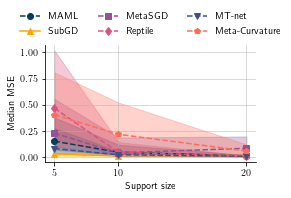

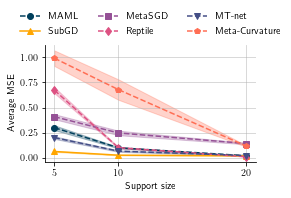

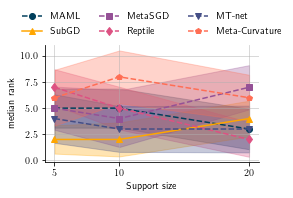

In [125]:
# plot results
figsize = (4, 3)
style = {
    'normal noise 0.0 ': {'ls': '--', 'col': '#003f5c', 'marker': 'o', 'label': 'MAML'},
    'normal-metasgd noise 0.0 ': {'ls': '--', 'col': '#955196', 'marker': 's', 'label': 'MetaSGD'},
    'normal mt-net': {'ls': '--', 'col': '#444e86', 'marker': 'v', 'label': 'MT-net'},
    'normal metacurvature': {'ls': '--', 'col': '#ff6e54', 'marker': 'p', 'label': 'Meta-Curvature'},
    'normal-reptile noise 0.0 ': {'ls': '--', 'col': '#dd5182', 'marker': 'd', 'label': 'Reptile'},
    'pca noise 0.0 ': {'ls': '-', 'col': '#ffa600', 'marker': '^', 'label': 'SubGD'},
}
exclude = [t for t in df_norms.columns.get_level_values("type") if 'no-pretrain' in t or 'supervised-pretrain' in t]
f = plot.plot_support_vs_mse(df_norms,
                             SUPPORT_SIZES,
                             ranks=False,
                             figsize=figsize,
                             aggregation='median',
                             style=style,
                             alpha=0.3,
                             exclude_types=exclude,
                             metric_name='MSE')
f1 = plot.plot_support_vs_mse(df_norms,
                             SUPPORT_SIZES,
                             ranks=False,
                             aggregation='mean',
                             figsize=figsize,
                             exclude_types=exclude,
                             alpha=0.3,
                             style=style,
                             metric_name='MSE')
f1.savefig('plots/sinusoid-support-vs-mse-mean.pdf', bbox_inches='tight')
f2 = plot.plot_support_vs_mse(df_norms,
                              SUPPORT_SIZES,
                              ranks=True,
                              alpha=0.3,
                              exclude_types=exclude,
                              figsize=figsize,
                              style=style)

11:27:07 WARNING:No handles with labels found to put in legend.
11:27:08 WARNING:No handles with labels found to put in legend.


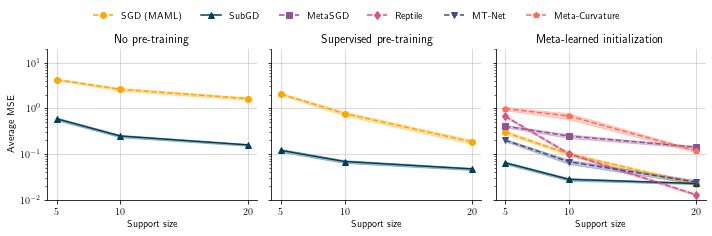

In [129]:
# plot results
style = {
    'normal noise 0.0 ': {'ls': '--', 'col': '#ffa600', 'marker': 'o', 'label': 'SGD (MAML)'},
    'pca noise 0.0 ': {'ls': '-', 'col': '#003f5c', 'marker': '^', 'label': 'SubGD'},
    'normal noise 0.0  no-pretrain': {'ls': '--', 'col': '#ffa600', 'marker': 'o', 'label': 'SGD'},
    'pca noise 0.0  no-pretrain': {'ls': '-', 'col': '#003f5c', 'marker': '^', 'label': 'SubGD'},
    'normal noise 0.0  supervised-pretrain': {'ls': '--', 'col': '#ffa600', 'marker': 'o', 'label': 'SGD'},
    'pca noise 0.0  supervised-pretrain': {'ls': '-', 'col': '#003f5c', 'marker': '^', 'label': 'SubGD'},
    'normal-metasgd noise 0.0 ': {'ls': '--', 'col': '#955196', 'marker': 's', 'label': 'MetaSGD'},
    'normal mt-net': {'ls': '--', 'col': '#444e86', 'marker': 'v', 'label': 'MT-Net'},
    'normal metacurvature': {'ls': '--', 'col': '#ff6e54', 'marker': 'p', 'label': 'Meta-Curvature'},
    'normal-reptile noise 0.0 ': {'ls': '--', 'col': '#dd5182', 'marker': 'd', 'label': 'Reptile'},
}
exclude = [t for t in df_norms.columns.get_level_values("type") if 'metasgd' in t]
f, axs = plt.subplots(1, 3, figsize=(10, 3), sharey=True, sharex=True)
for i in range(3):
    excl = [['supervised-pretrain', 'noise 0.0 ', 'normal mt-net', 'normal metacurvature'],
            ['no-pretrain', 'noise 0.0 ', 'normal mt-net', 'normal metacurvature'],
            ['no-pretrain', 'supervised-pretrain']]
    i_exclude = [t[1] for t in metrics[0.0].keys() if any(t[1].endswith(ex) for ex in excl[i])] \
        + (exclude if i != 2 else [])
    f_style = copy.deepcopy(style)
    if i != 2:
        for k in f_style.keys():
            f_style[k]['label'] = None
    f1 = plot.plot_support_vs_mse(df_norms,
                                 SUPPORT_SIZES,
                                 ranks=False,
                                 aggregation='mean',
                                 figsize=figsize,
                                 exclude_types=i_exclude,
                                 alpha=0.3,
                                 style=f_style,
                                  ax=axs[i],
                                 metric_name='MSE')
    axs[i].get_legend().remove()
    axs[i].set_ylim(0.01, 20)
    if i > 0:
        axs[i].set_ylabel('')
    axs[i].set_title('No pre-training' if i==0 else ('Supervised pre-training' if i==1 else 'Meta-learned initialization'))
plt.figlegend(frameon=False, loc='lower center', bbox_to_anchor=(0.5, 0.97), ncol=6)
plt.yscale('log')
plt.tight_layout()
plt.savefig('plots/sinusoid-support-vs-mse-pretraining.pdf', bbox_inches='tight')

In [127]:
# significance test
p = {}
noise = 0.0
sig_df = df_norms.groupby(['support', 'type'], axis=1).agg(lambda s: s.mean(skipna=False))
best_typs = {support: sig_df.loc[:, support].mean().idxmin(axis=1) for support in SUPPORT_SIZES}
for support, typ in sig_df.columns:
    if typ == f'{best_typs[support]} noise 0.0 ':
        p[(support, typ)] = np.nan
        continue
    if ((sig_df.loc[:, (support, typ)] - sig_df.loc[:, (support, best_typs[support])]) == 0).all():
        p[(support, typ)] = np.nan
        continue
    p[(support, typ)] = wilcoxon(sig_df.loc[:, (support, typ)], sig_df.loc[:, (support, best_typs[support])])[1]
sig_df = pd.DataFrame(p, index=['p-value']).T
sig_df.index.names = ['support', 'type']
display(sig_df.reset_index().pivot(index='type', columns='support', values='p-value').style.format('{:.3e}'))

support,5,10,20
type,,,
normal metacurvature,1.073e-15,7.452e-16,1.204e-14
normal mt-net,8.306e-08,5.667e-05,4.180e-02
normal noise 0.0,3.977e-17,1.084e-13,1.063e-02
normal noise 0.0 no-pretrain,8.778e-18,2.964e-17,4.961e-18
normal noise 0.0 supervised-pretrain,8.519e-18,1.219e-17,1.019e-17
normal-metasgd noise 0.0,2.610e-16,3.457e-11,2.396e-16
normal-reptile noise 0.0,1.256e-17,2.439e-09,nan
pca noise 0.0,nan,nan,1.933e-07
pca noise 0.0 no-pretrain,2.006e-14,1.015e-15,4.532e-18


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1761 out of 1761 | elapsed:    5.2s finished
100%|██████████| 353/353 [07:29<00:00,  1.27s/it]
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1761 out of 1761 | elapsed:    6.6s finished
100%|██████████| 353/353 [15:09<00:00,  2.58s/it]
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1761 out of 1761 | elapsed:    7.1s finished
100%|██████████| 353/353 [07:31<00:00,  1.28s/it]


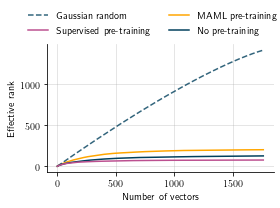

In [132]:
plt.figure(figsize=(4, 3))
for run, init_epoch, label, col in zip([RUNS[5]['maml'], RUNS['no-pretrain'],  RUNS['supervised-pretrain']],
                                       [50000, 1, 130],
                                       ['MAML pre-training', 'No pre-training', 'Supervised pre-training'],
                                       ['#ffa600', '#003f5c', '#bc5090']):
    finetune_dirs = list((run / f'finetune_epoch{init_epoch}').glob('sinus*/'))
    cfg = Config(run / 'config.yml')

    f, ax = plot.plot_deltas_rank(cfg, finetune_dirs,
                                  tols=[0],
                                  ax=plt.gca(),
                                  random_baseline=run==RUNS['no-pretrain'],
                                  n_repeats=1,
                                  task_steps=5,
                                  within_task_steps=None,
                                  epoch_steps=None,
                                  use_erank=True,
                                  colors=[col],
                                  init_epoch=init_epoch,
                                  label_suffix=label,
                                  plot_details=False,
                                  plot_val_metric=False)
plt.tight_layout()
plt.savefig(f'plots/sinus-pretrain-erank.pdf', bbox_inches='tight')